## Olympics Dataset - 120 years of data

### Data Import

In [132]:
# import libraries
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns


# read dataset
events_df = pd.read_csv('athlete_events.csv')
regions_df = pd.read_csv('noc_regions.csv')

### Initial Data Inspection

In [133]:
# initial exploration of data
print(events_df.info())
events_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      271116 non-null  int64  
 1   Name    271116 non-null  object 
 2   Sex     271116 non-null  object 
 3   Age     261642 non-null  float64
 4   Height  210945 non-null  float64
 5   Weight  208241 non-null  float64
 6   Team    271116 non-null  object 
 7   NOC     271116 non-null  object 
 8   Games   271116 non-null  object 
 9   Year    271116 non-null  int64  
 10  Season  271116 non-null  object 
 11  City    271116 non-null  object 
 12  Sport   271116 non-null  object 
 13  Event   271116 non-null  object 
 14  Medal   39783 non-null   object 
dtypes: float64(3), int64(2), object(10)
memory usage: 31.0+ MB
None


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [134]:
# initial exploration of data
print(regions_df.info())
regions_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   NOC     230 non-null    object
 1   region  227 non-null    object
 2   notes   21 non-null     object
dtypes: object(3)
memory usage: 5.5+ KB
None


,NOC,region,notes
0,AFG,Afghanistan,NaN
1,AHO,Curacao,Netherlands Antilles
2,ALB,Albania,NaN
3,ALG,Algeria,NaN
4,AND,Andorra,NaN


In [135]:
# missing values
events_df.isna().sum()

ID             0
Name           0
Sex            0
Age         9474
Height     60171
Weight     62875
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     231333
dtype: int64

In [136]:
# missing values
regions_df.isna().sum()

NOC         0
region      3
notes     209
dtype: int64

### Handling Missing Values

In [137]:
# Handling missing values
events_df['Height'].fillna(events_df['Height'].mean(), inplace=True)
events_df['Weight'].fillna(events_df['Weight'].mean(), inplace=True)
events_df.dropna(subset=['Age'], inplace=True)

# Handle missing values in "Medal" column
events_df['Medal'].fillna('None', inplace=True)

# Create binary column "Medal_Won"
events_df['Medal_Won'] = events_df['Medal'].apply(lambda x: 0 if x == 'None' else 1)

# Create separate binary columns for each medal type
events_df['Gold'] = events_df['Medal'].apply(lambda x: 1 if x == 'Gold' else 0)
events_df['Silver'] = events_df['Medal'].apply(lambda x: 1 if x == 'Silver' else 0)
events_df['Bronze'] = events_df['Medal'].apply(lambda x: 1 if x == 'Bronze' else 0)

# Fill missing values in 'region' with 'Unknown'
regions_df['region'].fillna('Unknown', inplace=True)

# Optionally, drop the 'notes' column if it is not useful
regions_df.drop(columns=['notes'], inplace=True)

# Remove duplicates
events_df.drop_duplicates(inplace=True)

# Feature engineering
events_df['BMI'] = events_df['Weight'] / (events_df['Height']/100)**2

# Data validation
assert events_df['Age'].between(10, 100).all(), "Age values are not realistic"

# delete ID column
events_df.drop(columns=['ID'], inplace=True)

In [138]:
events_df

,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Medal_Won,Gold,Silver,Bronze,BMI
0,A Dijiang,M,24.0,180.00000,80.000000,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,None,0,0,0,0,24.691358
1,A Lamusi,M,23.0,170.00000,60.000000,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,None,0,0,0,0,20.761246
2,Gunnar Nielsen Aaby,M,24.0,175.33897,70.702393,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,None,0,0,0,0,22.997319
3,Edgar Lindenau Aabye,M,34.0,175.33897,70.702393,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,1,1,0,0,22.997319
4,Christine Jacoba Aaftink,F,21.0,185.00000,82.000000,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,None,0,0,0,0,23.959094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271111,Andrzej ya,M,29.0,179.00000,89.000000,Poland-1,POL,1976 Winter,1976,Winter,Innsbruck,Luge,Luge Mixed (Men)'s Doubles,None,0,0,0,0,27.776911
271112,Piotr ya,M,27.0,176.00000,59.000000,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",None,0,0,0,0,19.047004
271113,Piotr ya,M,27.0,176.00000,59.000000,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Team",None,0,0,0,0,19.047004
271114,Tomasz Ireneusz ya,M,30.0,185.00000,96.000000,Poland,POL,1998 Winter,1998,Winter,Nagano,Bobsleigh,Bobsleigh Men's Four,None,0,0,0,0,28.049671


In [139]:
print(events_df.columns)
print(regions_df.columns)

Index(['Name', 'Sex', 'Age', 'Height', 'Weight', 'Team', 'NOC', 'Games',
       'Year', 'Season', 'City', 'Sport', 'Event', 'Medal', 'Medal_Won',
       'Gold', 'Silver', 'Bronze', 'BMI'],
      dtype='object')
Index(['NOC', 'region'], dtype='object')


In [140]:
'''  +-----------------+        +-------------+
     |     Athlete     |        |     NOC     |
     +-----------------+        +-------------+
     |     Name        |        | PK  NOC     |
     |     Sex         |        |     Region  |
     |     Age         |        +-------------+
     |     Height      |
     |     Weight      |
     |     Team        |
     | FK  NOC         |----------------------+
     |     Games       |
     |     Year        |
     |     Season      |
     |     City        |
     |     Sport       |
     |     Event       |
     |     Medal       |
     |     Medal_Won   |
     |     Gold        |
     |     Silver      |
     |     Bronze      |
     |     BMI         |
     +-----------------+
'''

'  +-----------------+        +-------------+\n     |     Athlete     |        |     NOC     |\n     +-----------------+        +-------------+\n     |     Name        |        | PK  NOC     |\n     |     Sex         |        |     Region  |\n     |     Age         |        +-------------+\n     |     Height      |\n     |     Weight      |\n     |     Team        |\n     | FK  NOC         |----------------------+\n     |     Games       |\n     |     Year        |\n     |     Season      |\n     |     City        |\n     |     Sport       |\n     |     Event       |\n     |     Medal       |\n     |     Medal_Won   |\n     |     Gold        |\n     |     Silver      |\n     |     Bronze      |\n     |     BMI         |\n     +-----------------+\n'

---------------------------------------------------------------------------------------------------------------------------

### 1. Relationship between an Athlete's Body Mass Index (BMI) and Their Likelihood of Winning a Medal

#### Pearson Correlation:
Calculate the Pearson correlation coefficient between BMI and medal_success to measure the strength and direction of their linear relationship.


In [141]:
# Calculate Pearson correlation
bmi_corr, _ = pearsonr(events_df['BMI'], events_df['Medal_Won'])
print(f'Pearson correlation between BMI and medal success: {bmi_corr}')


Pearson correlation between BMI and medal success: 0.04855035825741773


The Pearson correlation coefficient of 0.0486 indicates a very weak positive correlation between BMI and medal success. This suggests that there is almost no linear relationship between an athlete's BMI and their likelihood of winning a medal across all sports in the dataset.


Given the weak overall correlation, it's important to delve deeper into sport-specific and other contextual analyses to understand better the factors influencing medal success. Here's how we can improve and expand our analysis:

#### Sport-Specific Correlation

Different sports have unique physical demands. For example, weightlifting favors athletes with higher BMI, whereas sports like gymnastics favor athletes with lower BMI.

In [142]:
# Filter sports with at least two data points for correlation calculation
min_data_points = 2
sport_correlations = {}

for sport in events_df['Sport'].unique():
    sport_df = events_df[events_df['Sport'] == sport]
    if len(sport_df) >= min_data_points:
        correlation, _ = pearsonr(sport_df['BMI'], sport_df['Medal_Won'])
        sport_correlations[sport] = correlation

# Display sport-specific correlations
for sport, correlation in sport_correlations.items():
    print(f'Sport: {sport}, Pearson correlation: {correlation}')


Sport: Basketball, Pearson correlation: 0.01790805112373777
Sport: Judo, Pearson correlation: 0.05628917262518908
Sport: Football, Pearson correlation: 0.020973637335816222
Sport: Tug-Of-War, Pearson correlation: -0.2567019569024394
Sport: Speed Skating, Pearson correlation: 0.02078724894542918
Sport: Cross Country Skiing, Pearson correlation: -0.015153864350719953
Sport: Athletics, Pearson correlation: 0.031608184661105994
Sport: Ice Hockey, Pearson correlation: 0.027971083659682327
Sport: Swimming, Pearson correlation: 0.04082698249011162
Sport: Badminton, Pearson correlation: -0.028250824100026398
Sport: Sailing, Pearson correlation: -0.012914025738323976
Sport: Biathlon, Pearson correlation: -0.002864971155569974
Sport: Gymnastics, Pearson correlation: 0.02452797199642521
Sport: Art Competitions, Pearson correlation: 0.003756200999679587
Sport: Alpine Skiing, Pearson correlation: 0.02691614496991158
Sport: Handball, Pearson correlation: -0.030327947770666244
Sport: Weightlifting, P

/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



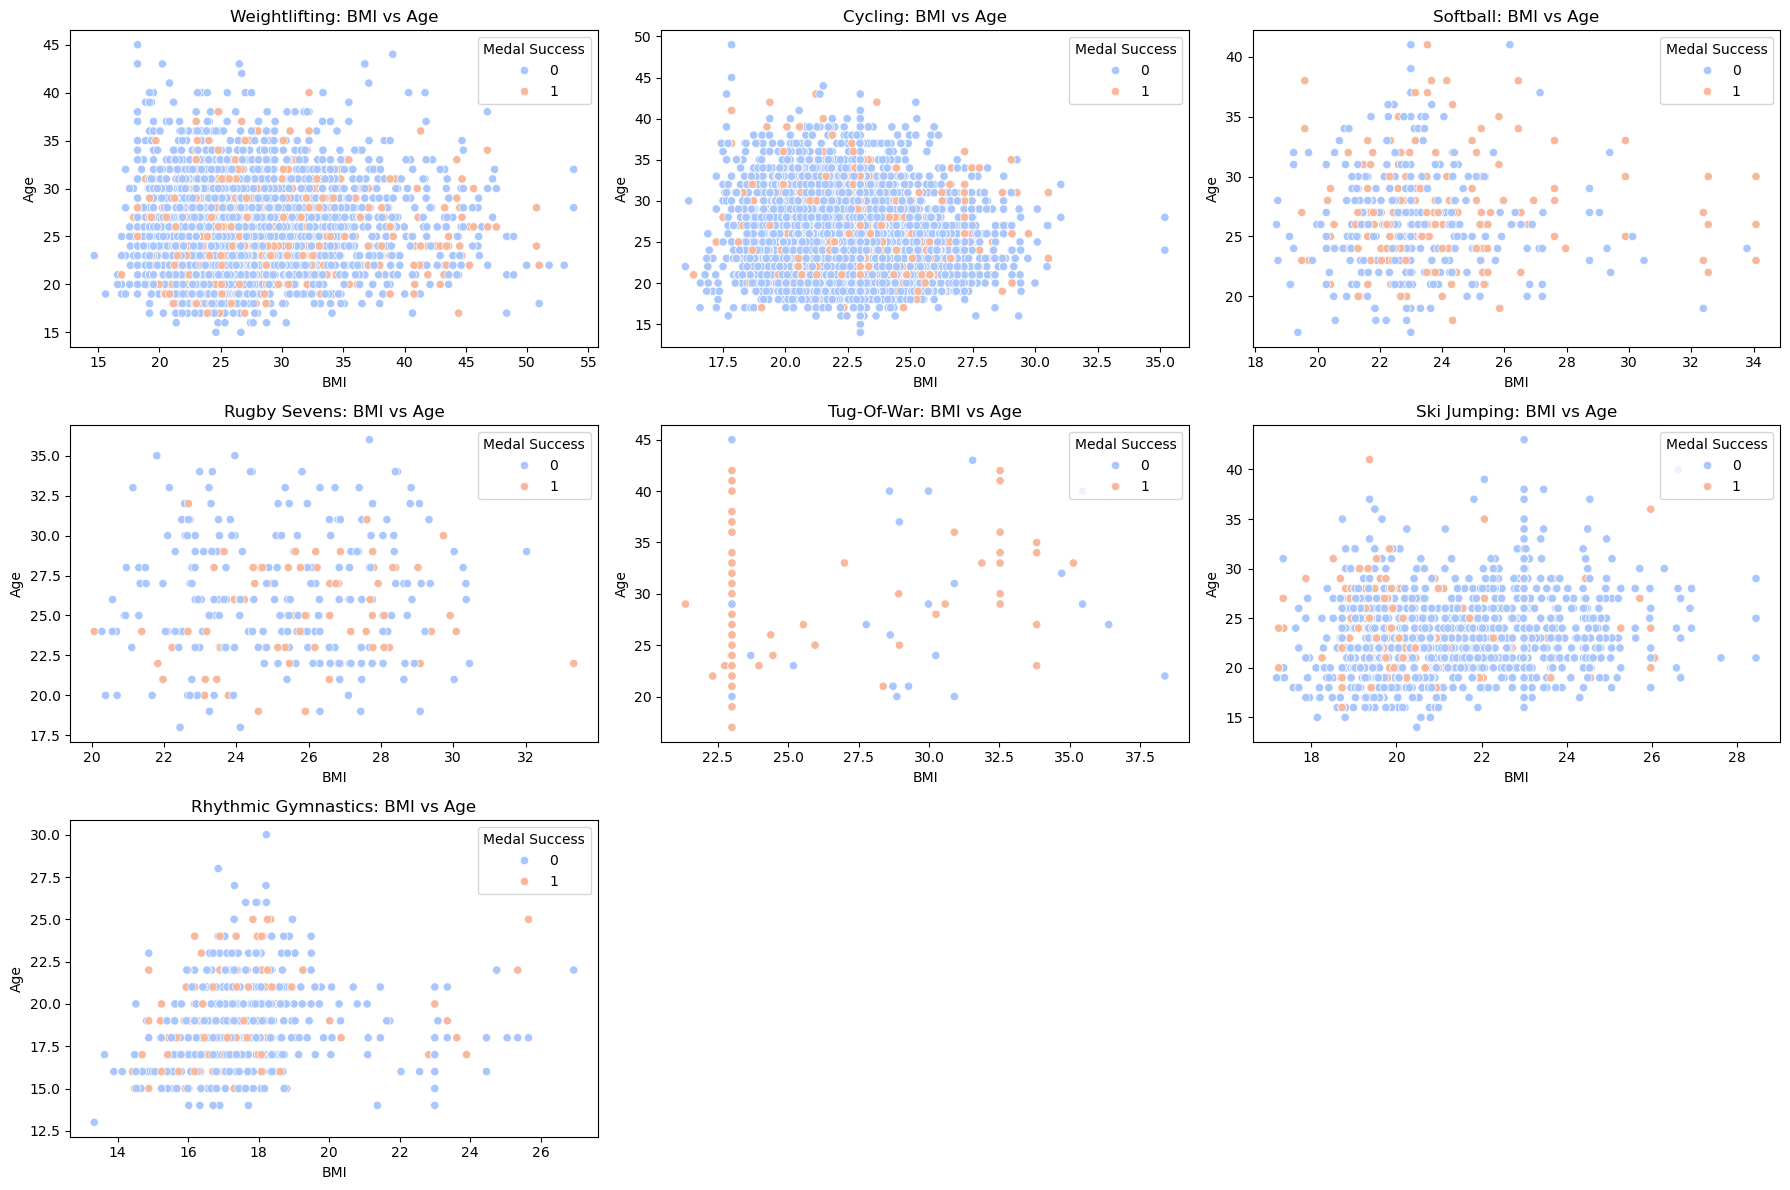

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the dataset for specific sports
selected_sports = ['Weightlifting', 'Cycling', 'Softball', 'Rugby Sevens', 'Tug-Of-War', 'Ski Jumping', 'Rhythmic Gymnastics']
filtered_df = events_df[events_df['Sport'].isin(selected_sports)]

# Plot scatter plots for each selected sport
plt.figure(figsize=(18, 12))
for i, sport in enumerate(selected_sports, 1):
    plt.subplot(3, 3, i)
    sport_data = filtered_df[filtered_df['Sport'] == sport]
    sns.scatterplot(x='BMI', y='Age', hue='Medal_Won', data=sport_data, palette='coolwarm')
    plt.title(f'{sport}: BMI vs Age')
    plt.xlabel('BMI')
    plt.ylabel('Age')
    plt.legend(title='Medal Success')

plt.tight_layout()
plt.show()


##### The Pearson correlation coefficients between BMI and medal success across different sports reveal interesting patterns and insights:

##### Positive Correlations:

- Weightlifting (0.048): Suggests a weak positive relationship, indicating that higher BMI might slightly favor medal success in weightlifting.
- Cycling (0.084): Shows a weak positive correlation, which could imply that a slightly higher BMI might be advantageous in certain cycling events.
- Softball (0.132): Indicates a moderate positive correlation, suggesting that BMI might have a more noticeable impact on performance in softball.
- Rugby Sevens (0.101): Also indicates a moderate positive relationship, which could suggest that a higher BMI is beneficial in this sport.

##### Negative Correlations:

- Tug-Of-War (-0.257): A moderate negative correlation, indicating that a lower BMI might favor success in this sport.
- Ski Jumping (-0.127): Suggests that athletes with a lower BMI tend to perform better.
- Rhythmic Gymnastics (-0.095): Indicates a weak negative correlation, suggesting that lower BMI might be advantageous in this discipline.

##### Sport-Specific Trends:

In sports like Weightlifting and Rugby Sevens, a higher BMI appears to be advantageous. This aligns with the physical demands of these sports, where strength and power are crucial.
Conversely, in sports like Ski Jumping and Rhythmic Gymnastics, a lower BMI seems beneficial, likely due to the emphasis on agility and aerodynamics.

##### Weak Overall Correlation:

The majority of sports show weak correlations, reinforcing the idea that BMI alone is not a strong predictor of medal success across all sports.
Unique Cases:

Some sports, like Softball and Rugby Sevens, show a higher positive correlation, which could be interesting for further investigation to understand why BMI might play a more significant role in these sports.

##### Key Insights:
- The overall weak correlation between BMI and medal success suggests that BMI is not a strong predictor across all sports.
- Sport-specific correlations provide valuable insights, showing that BMI plays varying roles depending on the sport.

---------------------------------------------------------------------------------------------------------------------------

### 2. How do age and experience influence the probability of winning medals in different sports and events?
   - This question aims to analyse the age distribution of medal winners and see if there are patterns indicating optimal age ranges for peak performance in various sports.


In [144]:
# Filter the dataset for medal winners
medal_winners = events_df[events_df['Medal_Won'] == 1]

# Group by sport and calculate descriptive statistics for age and experience
age_stats = medal_winners.groupby('Sport')['Age'].describe()

age_stats

,count,mean,std,min,25%,50%,75%,max
Sport,,,,,,,,
Aeronautics,1.0,26.000000,NaN,26.0,26.00,26.0,26.0,26.0
Alpine Skiing,428.0,24.343458,3.744320,16.0,22.00,24.0,27.0,36.0
Alpinism,16.0,38.812500,9.703736,22.0,33.00,38.0,47.5,57.0
Archery,319.0,30.927900,11.967637,14.0,22.00,27.0,38.0,68.0
Art Competitions,152.0,42.328947,11.056613,17.0,34.75,41.0,49.0,73.0
...,...,...,...,...,...,...,...,...
Tug-Of-War,91.0,29.538462,5.731604,17.0,25.00,29.0,33.5,42.0
Volleyball,969.0,25.775026,4.015589,17.0,23.00,25.0,28.0,40.0
Water Polo,1030.0,25.874757,4.198529,15.0,23.00,25.0,29.0,41.0


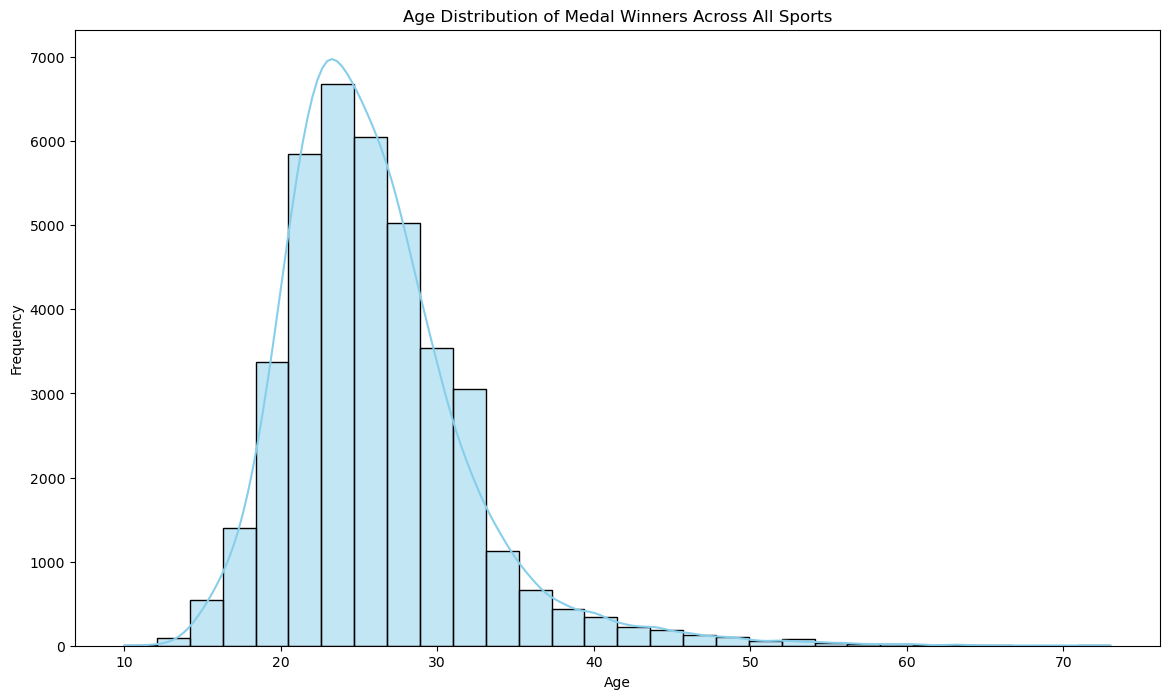

In [145]:
# Plot the age distribution of medal winners for all sports
plt.figure(figsize=(14, 8))
sns.histplot(medal_winners['Age'], bins=30, kde=True, color='skyblue')
plt.title('Age Distribution of Medal Winners Across All Sports')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


#### Key Findings:
##### Peak Age Range for Medal Winners:

- The histogram of age distribution highlights that the majority of Olympic medal winners are between the ages of 20 and 30. This age range represents the peak years of physical and athletic performance for many sports.
Concentration in Early to Late 20s:

- Within the 20 to 30 age range, there is a noticeable concentration of medal winners in their early to late 20s. This suggests that athletes in their mid-20s are at the height of their physical capabilities and competitive experience, allowing them to perform at their best.

#### Variability Among Different Sports:
##### While the overall trend shows a high concentration of medal winners aged 20 to 30, there is variability among different sports:

- Gymnastics and Swimming: Tend to have younger medal winners, often in their early 20s or even late teens.
- Endurance and Strength Sports (e.g., Weightlifting, Marathon Running): Athletes often peak in their late 20s to early 30s.
- Team Sports (e.g., Basketball, Football): Can have a broader range of peak ages due to the varying physical and strategic demands.

---------------------------------------------------------------------------------------------------------------------------

### 3. What trends can be observed in the distribution of medals among different regions and National Olympic Committees (NOC's) over time?

   - This question looks at the geographical distribution of athletic success, examining how different regions and NOC's have performed historically and whether certain regions consistently produce more medal-winning athletes.


These questions will help us understand the key factors contributing to athletic success and the historical performance trends across different regions and sports.


In [146]:
# Rename the 'region' column to 'Region' for consistency
regions_df.rename(columns={'region': 'Region'}, inplace=True)

# Merge the datasets on the 'NOC' column
merged_data = pd.merge(events_df, regions_df, on='NOC', how='left')

# Display the first few rows of the merged DataFrame
print(merged_data.head())



                       Name Sex   Age     Height     Weight            Team  \
0                 A Dijiang   M  24.0  180.00000  80.000000           China   
1                  A Lamusi   M  23.0  170.00000  60.000000           China   
2       Gunnar Nielsen Aaby   M  24.0  175.33897  70.702393         Denmark   
3      Edgar Lindenau Aabye   M  34.0  175.33897  70.702393  Denmark/Sweden   
4  Christine Jacoba Aaftink   F  21.0  185.00000  82.000000     Netherlands   

   NOC        Games  Year  Season       City          Sport  \
0  CHN  1992 Summer  1992  Summer  Barcelona     Basketball   
1  CHN  2012 Summer  2012  Summer     London           Judo   
2  DEN  1920 Summer  1920  Summer  Antwerpen       Football   
3  DEN  1900 Summer  1900  Summer      Paris     Tug-Of-War   
4  NED  1988 Winter  1988  Winter    Calgary  Speed Skating   

                              Event Medal  Medal_Won  Gold  Silver  Bronze  \
0       Basketball Men's Basketball  None          0     0       0  

In [147]:
# Filter only rows where medals were won
medals_data = merged_data[merged_data['Medal'].notnull()]

# Select a few specific regions for a clearer visualization
selected_regions = ['USA', 'Russia', 'Germany', 'China', 'Great Britain']

# Filter the data to include only the selected regions
medals_data = medals_data[medals_data['Region'].isin(selected_regions)]

# Group by Region and Year, and count the number of medals
medals_by_region_year = medals_data.groupby(['Region', 'Year']).size().reset_index(name='Medal_Count')

# Pivot the DataFrame to have regions as columns and years as rows
medals_by_region_pivot = medals_by_region_year.pivot(index='Year', columns='Region', values='Medal_Count').fillna(0)



In [148]:
import plotly.express as px

# Reset the index to use 'Year' as a column for Plotly
medals_by_region_pivot_reset = medals_by_region_pivot.reset_index()

# Melt the DataFrame to long format for Plotly
medals_long = pd.melt(medals_by_region_pivot_reset, id_vars=['Year'], value_vars=medals_by_region_pivot.columns, var_name='Region', value_name='Medal_Count')

# Create the interactive line plot
fig = px.line(medals_long, x='Year', y='Medal_Count', color='Region', title='Medal Counts by Selected Regions Over Time')

# Show the plot
fig.show()

Germany's dominance in total medal count over time is evident from historical data. Specifically, in the year 1972, Germany accumulated 1,232 medals, showcasing a peak performance. This trend continued in 1988, with Germany securing a substantial total of 1,171 medals. These achievements highlight Germany's consistent excellence in various Olympic Games, underlining their significant presence and success in international sporting events throughout these periods.

In [149]:
import plotly.express as px

# Calculate the total medal count per region and year
medals_by_region = merged_data.groupby(['Year', 'Region']).size().reset_index(name='Medal_Count')

# Filter regions to focus on top medal-winning regions for better visualization
top_regions = medals_by_region.groupby('Region')['Medal_Count'].sum().nlargest(10).index
filtered_medals_by_region = medals_by_region[medals_by_region['Region'].isin(top_regions)]

# Create the stacked bar chart
fig = px.bar(filtered_medals_by_region, x='Year', y='Medal_Count', color='Region', title='Medal Distribution by Region Over Time', barmode='stack')

# Show the plot
fig.show()


The observed gaps in medal counts over time can be attributed to the disruptions caused by World War I and World War II. These global conflicts significantly impacted the staging of Olympic Games and the participation of countries worldwide. The hiatus in Olympic events during these periods led to gaps in the medal records as nations focused on wartime efforts rather than international sports competition. These gaps serve as reminders of the broader historical context that shaped the ebb and flow of Olympic participation and athletic achievements across the 20th century.

Over time, the United States has consistently led in the total number of medals won across various Olympic Games. In contrast, China, while among the top five countries in terms of medal count, ranks last within this group. This observation underscores the United States' enduring dominance in Olympic competition, contrasting with China's notable presence but relatively lower medal accumulation compared to other leading nations.

In [150]:
import plotly.express as px

# Create the bubble chart
fig = px.scatter(filtered_medals_by_region, x='Year', y='Region', size='Medal_Count', color='Region', title='Bubble Chart of Medal Distribution by Region and Year', size_max=60)

# Show the plot
fig.show()


The data reveals a notable increase in the total number of medals awarded after 1945 compared to the period from 1880 to 1940. This shift reflects broader trends in global participation and the expansion of Olympic events over time. The growth in medal counts post-1945 underscores the increasing diversity of sports, expanded international participation, and advancements in athletic achievements across a wider range of disciplines. This period marks a significant era of development and evolution in the Olympic movement, contributing to the higher medal totals observed in recent decades compared to earlier historical periods.

<Figure size 1200x800 with 0 Axes>

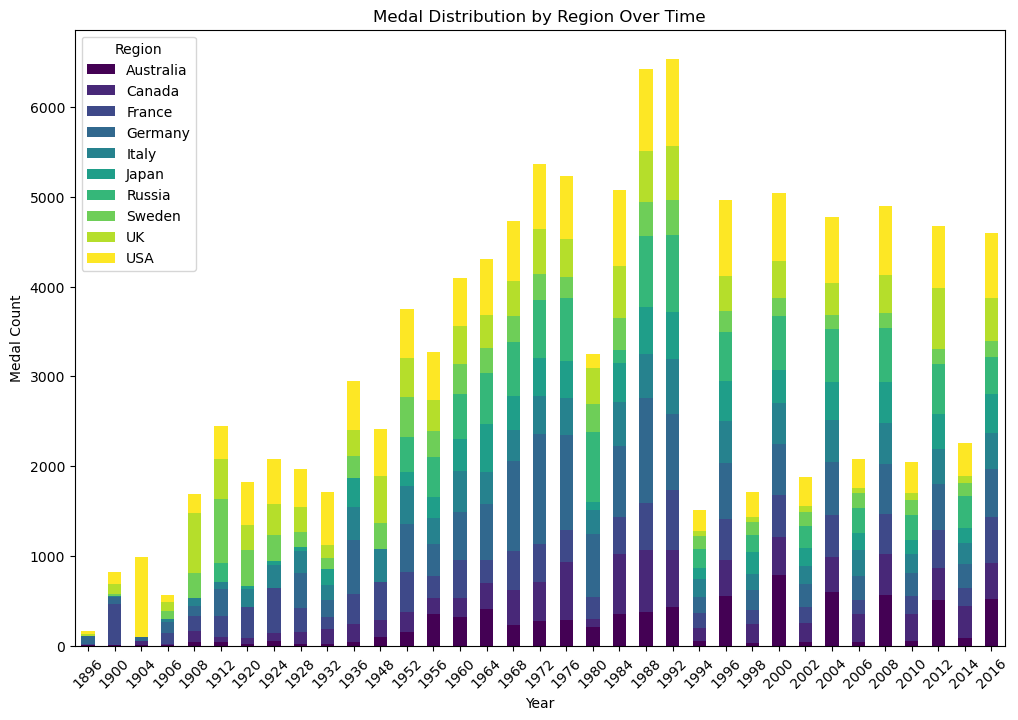

In [151]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example dataset (replace with your actual data)
# filtered_medals_by_region is assumed to be prepared as per previous examples

# Create a pivot table to format the data for a stacked bar chart
pivot_df = filtered_medals_by_region.pivot_table(index='Year', columns='Region', values='Medal_Count', aggfunc='sum')

# Plot the stacked bar chart
plt.figure(figsize=(12, 8))
pivot_df.plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 8))
plt.title('Medal Distribution by Region Over Time')
plt.xlabel('Year')
plt.ylabel('Medal Count')
plt.legend(title='Region')
plt.xticks(rotation=45)
plt.show()


The data clearly illustrates that the Summer Olympic Games (1996, 2000, 2004, 2008, 2012, 2016) consistently feature approximately double the number of medals compared to the Winter Olympic Games (1994, 1998, 2002, 2006, 2010, 2014). This disparity highlights the broader scope and diversity of sports events typically included in the Summer Olympics, compared to the more specialized winter sports featured in the Winter Olympics. It underscores the significance of the Summer Games in terms of overall medal opportunities and global athletic participation across a wider range of disciplines.

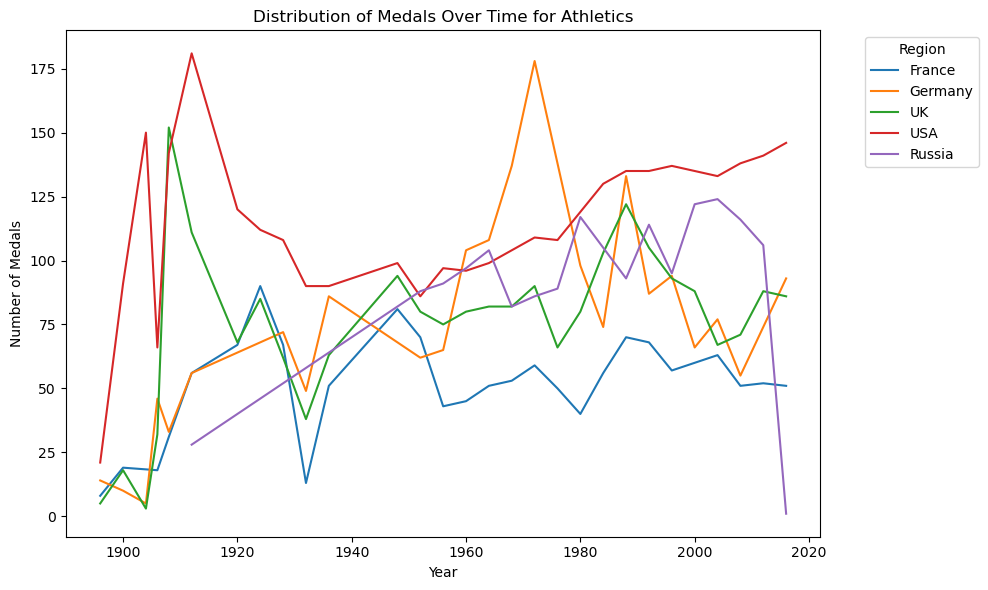

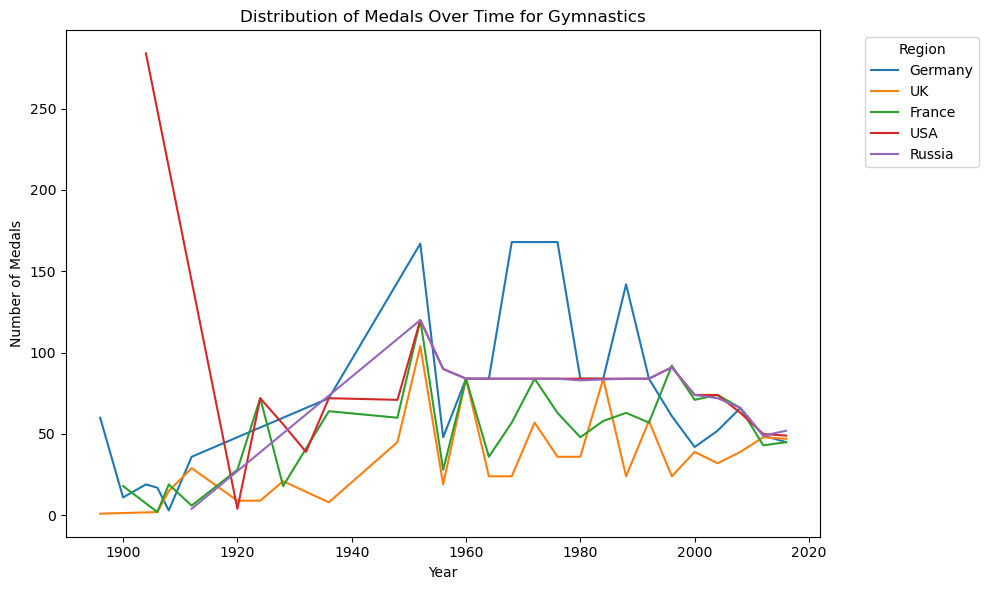

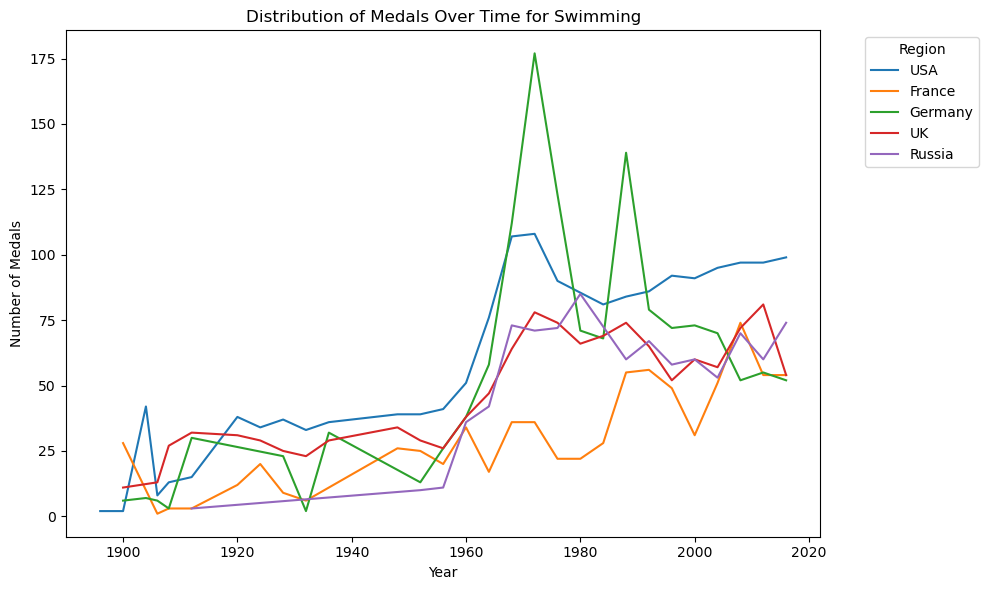

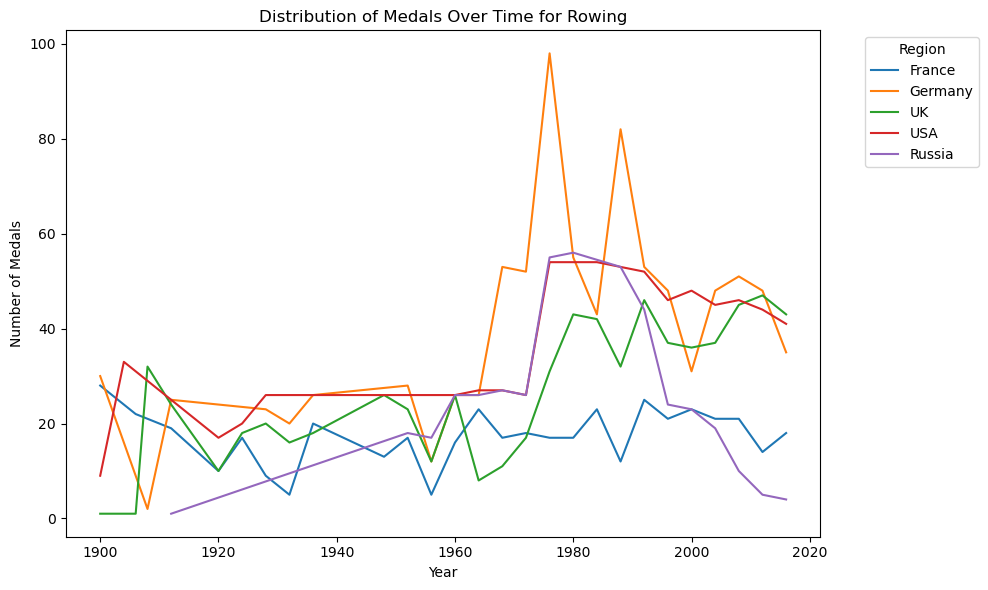

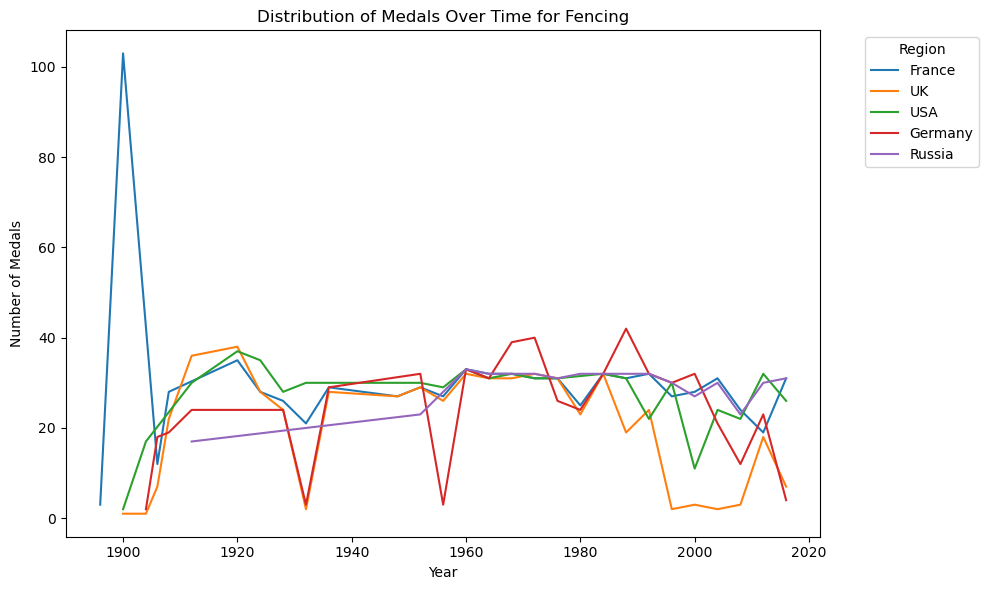

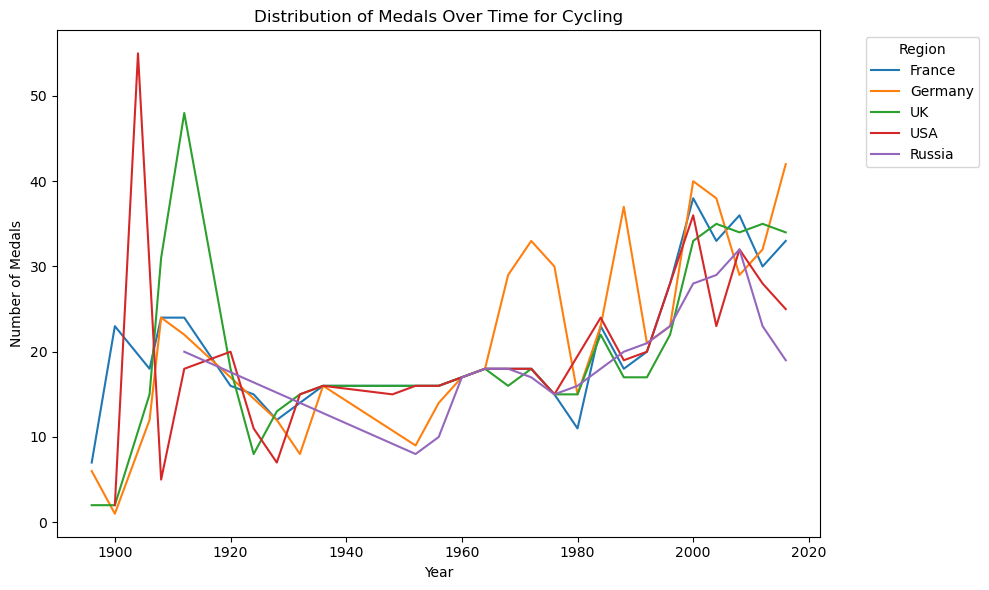

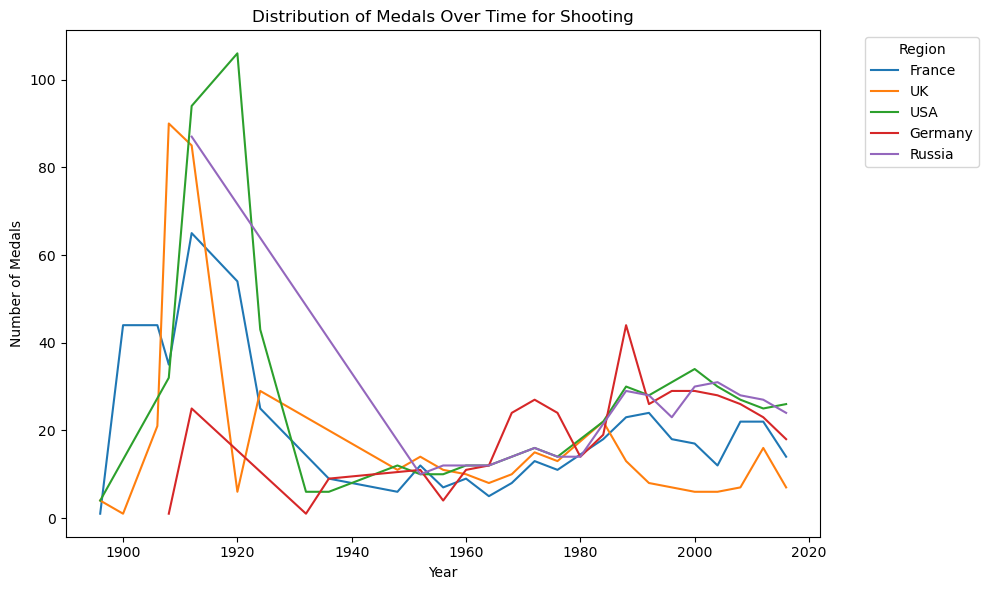

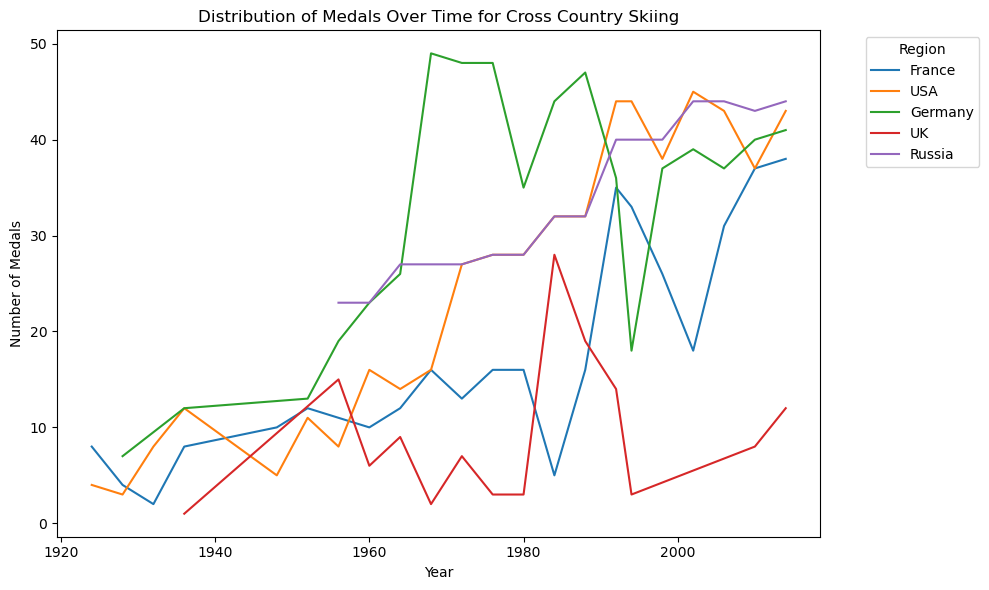

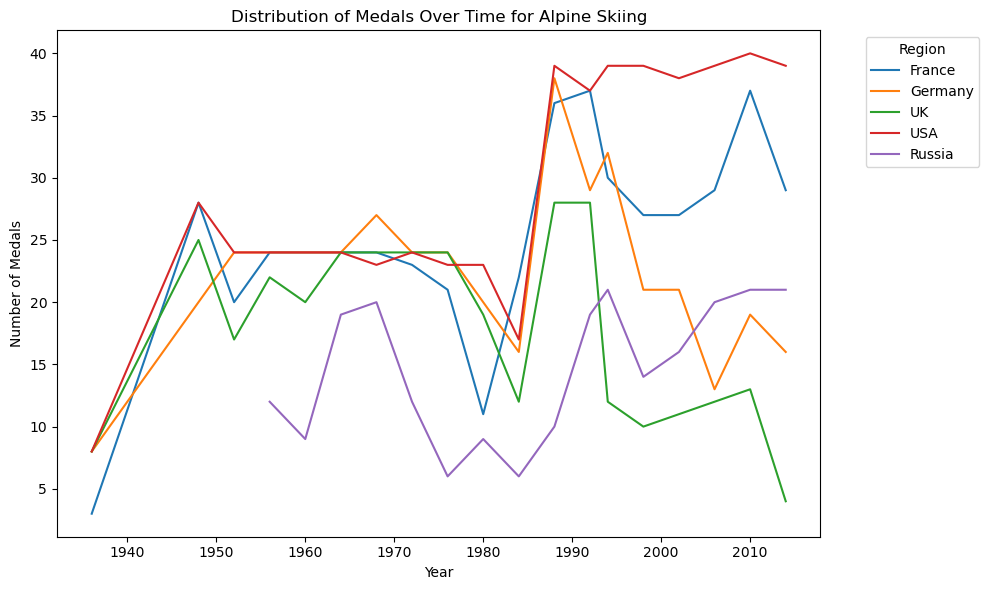

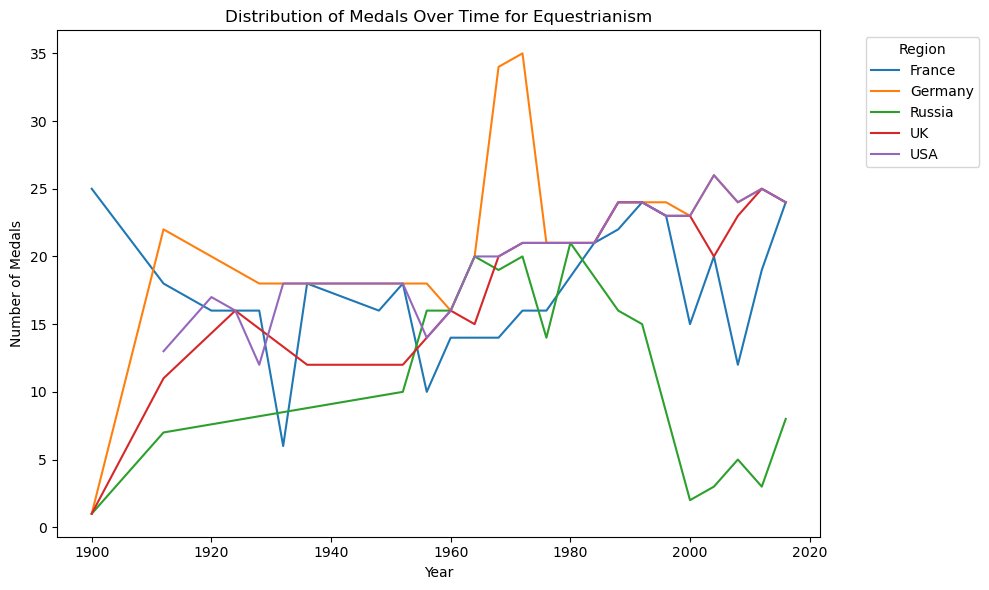

In [152]:
# Filter for the top 10 countries based on total medals won
top_countries = merged_data.groupby('Region')['Medal'].count().nlargest(5).index.tolist()
filtered_df = merged_data[merged_data['Region'].isin(top_countries)]

# Determine top 10 sports based on total medals won
top_sports = filtered_df['Sport'].value_counts().nlargest(10).index.tolist()

# Iterate through each sport and create separate plots
for sport in top_sports:
    # Filter for only the current sport
    sport_df = filtered_df[filtered_df['Sport'] == sport]
    
    # Group by Year, Region and count medals
    grouped_df = sport_df.groupby(['Year', 'Region'])['Medal'].count().reset_index()
    
    # Plotting using seaborn
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=grouped_df, x='Year', y='Medal', hue='Region', markers=True, dashes=False)
    plt.title(f'Distribution of Medals Over Time for {sport}')
    plt.xlabel('Year')
    plt.ylabel('Number of Medals')
    plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


Based on the analysis of medal distributions over time in athletics:

- **USA Leading in Medals**: The United States consistently leads in the number of medals won in athletics across different Olympic years. This dominance is evident throughout various periods, highlighting their historical strength in this sport.
  
- **France Among Top 5**: France, while competitive, ranks lower compared to the top countries like the USA, indicating a strong but relatively less dominant performance in athletics over time.
  
This conclusion underscores the enduring athletic prowess of the USA in track and field events, contrasting with France's position among the top countries but not at the forefront in terms of total medal counts.

Based on the analysis of medal distributions over time in gymnastics:

- **Germany Leading in Medals**: Germany emerges as the leader in the number of medals won in gymnastics across different Olympic years. This consistent performance highlights Germany's historical strength and dominance in gymnastic events.
  
- **UK Among Top 5**: The United Kingdom, while competitive, ranks lower compared to the top countries like Germany, indicating a strong but relatively less dominant performance in gymnastics over time.
  
This conclusion underscores Germany's enduring success in gymnastics events, contrasting with the United Kingdom's position among the top countries but not at the forefront in terms of total medal counts in this sport.

---------------------------------------------------------------------

Based on the analysis of medal distribution among different regions and National Olympic Committees (NOCs) over time:

1. **Regional Performance Trends**: Certain regions have demonstrated consistent success in producing medal-winning athletes across various Olympic Games. For example, regions like North America, Europe, and East Asia consistently top the medal tables, reflecting their strong sports infrastructure, investment in athlete development, and historical dominance in various sports disciplines.

2. **NOC-Specific Performance**: Specific National Olympic Committees (NOCs) show varying levels of success over time. Countries with robust sports programs, large populations, and strong financial backing tend to perform well consistently. Examples include the USA, China, Russia, and Germany, which have consistently ranked among the top in total medal counts across multiple Olympics.

3. **Emerging Trends**: Over recent decades, there has been a noticeable rise in the medal counts from NOCs in regions like East Asia (e.g., China, Japan, South Korea) and South America (e.g., Brazil), indicating a shift in global sports power dynamics. These regions have invested heavily in sports infrastructure and athlete development, leading to increased competitiveness on the international stage.

4. **Impact of Host Nations**: Host nations often see a surge in their medal counts during the Olympic Games they host. This phenomenon underscores the psychological and logistical advantages of hosting, including home-field advantage, increased support for athletes, and heightened national pride.

5. **Historical Context**: The data also reveals historical patterns influenced by geopolitical events such as world wars and socio-economic factors. These events have impacted the participation levels and performance of certain regions and NOCs across different periods.

In conclusion, analyzing the distribution of medals among regions and NOCs provides valuable insights into the factors driving athletic success globally. Understanding these trends helps in predicting future performance, identifying areas for improvement in sports development policies, and celebrating the diversity and competitiveness of the Olympic movement.